The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Redes Usando Blocos (VGG)
:label:`sec_vgg`

Enquanto AlexNet ofereceu evidências empíricas de que CNNs profundas
pode alcançar bons resultados, não forneceu um modelo geral
para orientar os pesquisadores subsequentes na concepção de novas redes.
Nas seções a seguir, apresentaremos vários conceitos heurísticos
comumente usado para projetar redes profundas.

O progresso neste campo reflete aquele no design de chips
onde os engenheiros deixaram de colocar transistores
para elementos lógicos para blocos lógicos.
Da mesma forma, o projeto de arquiteturas de rede neural
tornou-se progressivamente mais abstrato,
com pesquisadores deixando de pensar em termos de
neurônios individuais para camadas inteiras,
e agora para blocos, repetindo padrões de camadas.

A ideia de usar blocos surgiu pela primeira vez a partir do
[Grupo de Geometria Visual](http://www.robots.ox.ac.uk/~vgg/) (VGG)
na Universidade de Oxford,
em sua rede de mesmo nome *VGG*.
É fácil implementar essas estruturas repetidas no código
com qualquer estrutura moderna de aprendizado profundo usando loops e sub-rotinas.

## VGG Blocks

O bloco de construção básico das CNNs clássicas
é uma sequência do seguinte:
(i) uma camada convolucional
com preenchimento para manter a resolução,
(ii) uma não linearidade, como um ReLU,
(iii) uma camada de pooling tal
como uma camada de pooling máxima.
Um bloco VGG consiste em uma sequência de camadas convolucionais,
seguido por uma camada de *pooling* máxima para *downsampling* espacial.
No artigo VGG original :cite:`Simonyan.Zisserman.2014`,
Os autores
convoluções empregadas com $3 \times 3$ kernels com preenchimento de 1 (mantendo a altura e largura)
e $2 \times 2$ *pool* máximo com passo de 2
(reduzindo pela metade a resolução após cada bloco).
No código abaixo, definimos uma função chamada `vgg_block`
para implementar um bloco VGG.

: begin_tab: `mxnet, tensorflow`
A função leva dois argumentos
correspondendo ao número de camadas convolucionais `num_convs`
e o número de canais de saída `num_channels`.
: end_tab:

: begin_tab: `pytorch`
A função leva três argumentos correspondentes ao número
de camadas convolucionais `num_convs`, o número de canais de entrada `in_channels`
e o número de canais de saída `out_channels`.
: end_tab:


In [1]:
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def vgg_block(num_convs, num_channels):
    blk = nn.Sequential()
    for _ in range(num_convs):
        blk.add(nn.Conv2D(num_channels, kernel_size=3,
                          padding=1, activation='relu'))
    blk.add(nn.MaxPool2D(pool_size=2, strides=2))
    return blk

## Camadas VGG 

Como AlexNet e LeNet,
a rede VGG pode ser dividida em duas partes:
o primeiro consistindo principalmente de camadas convolucionais e de *pooling*
e a segunda consistindo em camadas totalmente conectadas.
Isso é descrito em :numref:`fig_vgg`.

![De AlexNet a VGG que é projetado a partir de blocos de construção.](http://d2l.ai/_images/vgg.svg)
:width:`400px`
:label:`fig_vgg`

A parte convolucional da rede conecta vários blocos VGG de :numref:`fig_vgg` (também definido na função` vgg_block`)
em sucessão.
A seguinte variável `conv_arch` consiste em uma lista de tuplas (uma por bloco),
onde cada um contém dois valores: o número de camadas convolucionais
e o número de canais de saída,
quais são precisamente os argumentos necessários para chamar
a função `vgg_block`.
A parte totalmente conectada da rede VGG é idêntica à coberta no AlexNet.

A rede VGG original tinha 5 blocos convolucionais,
entre os quais os dois primeiros têm uma camada convolucional cada
e os três últimos contêm duas camadas convolucionais cada.
O primeiro bloco tem 64 canais de saída
e cada bloco subsequente dobra o número de canais de saída,
até que esse número chegue a 512.
Uma vez que esta rede usa 8 camadas convolucionais
e 3 camadas totalmente conectadas, geralmente chamado de VGG-11.


In [2]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

O código a seguir implementa VGG-11. Esta é uma simples questão de executar um loop for sobre `conv_arch`.


In [3]:
def vgg(conv_arch):
    net = nn.Sequential()
    # A parte convolucional
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # A parte totalmente conectada
    net.add(nn.Dense(4096, activation='relu'), nn.Dropout(0.5),
            nn.Dense(4096, activation='relu'), nn.Dropout(0.5),
            nn.Dense(10))
    return net

net = vgg(conv_arch)

A seguir, construiremos um exemplo de dados de canal único
com altura e largura de 224 para observar a forma de saída de cada camada.


In [4]:
net.initialize()
X = np.random.uniform(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.name, 'output shape:\t', X.shape)

sequential1 output shape:	 (1, 64, 112, 112)
sequential2 output shape:	 (1, 128, 56, 56)
sequential3 output shape:	 (1, 256, 28, 28)
sequential4 output shape:	 (1, 512, 14, 14)
sequential5 output shape:	 (1, 512, 7, 7)
dense0 output shape:	 (1, 4096)
dropout0 output shape:	 (1, 4096)
dense1 output shape:	 (1, 4096)
dropout1 output shape:	 (1, 4096)
dense2 output shape:	 (1, 10)


Como você pode ver, dividimos a altura e a largura em cada bloco,
finalmente alcançando uma altura e largura de 7
antes de achatar as representações
para processamento pela parte totalmente conectada da rede.

## Treinamento

Como o VGG-11 é mais pesado em termos computacionais do que o AlexNet
construímos uma rede com um número menor de canais.
Isso é mais do que suficiente para o treinamento em Fashion-MNIST.


In [5]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

Além de usar uma taxa de aprendizado um pouco maior,
o processo de treinamento do modelo é semelhante ao do AlexNet em :numref:`sec_alexnet`.


loss 0.177, train acc 0.935, test acc 0.927
1791.5 examples/sec on gpu(0)


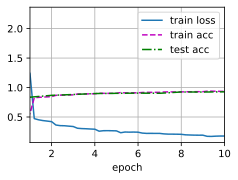

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Sumário

* VGG-11 constrói uma rede usando blocos convolucionais reutilizáveis. Diferentes modelos de VGG podem ser definidos pelas diferenças no número de camadas convolucionais e canais de saída em cada bloco.
* O uso de blocos leva a representações muito compactas da definição da rede. Ele permite um projeto eficiente de redes complexas.
* Em seu artigo VGG, Simonyan e Ziserman experimentaram várias arquiteturas. Em particular, eles descobriram que várias camadas de convoluções profundas e estreitas (ou seja, $3 \times 3$) eram mais eficazes do que menos camadas de convoluções mais largas.

## Exercícios

1. Ao imprimir as dimensões das camadas, vimos apenas 8 resultados, em vez de 11. Para onde foram as informações das 3 camadas restantes?
2. Comparado com o AlexNet, o VGG é muito mais lento em termos de computação e também precisa de mais memória GPU. Analise as razões disso.
3. Tente alterar a altura e a largura das imagens no Fashion-MNIST de 224 para 96. Que influência isso tem nos experimentos?
4. Consulte a Tabela 1 no artigo VGG :cite:`Simonyan.Zisserman.2014` para construir outros modelos comuns, como VGG-16 ou VGG-19.


[Discussions](https://discuss.d2l.ai/t/77)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTIwMTk1NzExNzksMTgzMjAxMzg4OF19
-->
